<a href="https://colab.research.google.com/github/ShovalBenjer/Bigdata_Pyspark_Spark_Hadoop_Apache/blob/ShovalBenjer-patch-1/integral_approximation_with_spark_1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook explores distributed numerical integration using Apache Spark integrated into google colabs jupyter notebooks, focusing on approximating the integral of a specific f(x) over a specified range. By varying the number of intervals n and Spark workers, the project evaluates the trade-offs between computation accuracy, execution time, and scalability in a distributed environment. The results demonstrate how increasing n improves precision while parallelism enhances performance, highlighting the efficiency and limitations of distributed systems for computational tasks.

**Setup = Imports and intiallize**

In [9]:
from pyspark import SparkContext
import time
import pandas as pd
from sympy import symbols, integrate
import logging
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

if SparkContext._active_spark_context:
    sc = SparkContext.getOrCreate()
else:
    sc = SparkContext("local", "Integral Approximation")

In [7]:
def f(x):
    """Function to calculate f(x) = 10x^2 - 2. Change the function for different approximation."""
    return 10 * x**2 - 2

def exact_integral_sympy(a, b):
    """
    Calculate the exact integral of f(x) using SymPy.

    Args:
        a (float): Lower bound of the integral.
        b (float): Upper bound of the integral.

    Returns:
        float: Exact integral value.
    """
    x = symbols('x')
    exact_integral = integrate(f(x), (x, a, b))
    exact_value = float(exact_integral)
    logging.info(f"Exact integral from {a} to {b}: {exact_value}")
    return exact_value

def calculate_integral(a, b, n, num_workers):
    """
    Calculate the integral approximation using Spark RDDs.

    Args:
        a (float): Lower bound of the integral.
        b (float): Upper bound of the integral.
        n (int): Number of intervals.
        num_workers (int): Number of Spark partitions (workers).

    Returns:
        float: Approximated integral value.
    """
    h = (b - a) / n
    x_values = [a + k * h for k in range(n + 1)]
    logging.info(f"Calculating integral with n={n}, num_workers={num_workers}")
    rdd = sc.parallelize(x_values, num_workers)
    integral_sum = rdd.map(f).reduce(lambda x, y: x + y)
    result = h * ((f(a) + f(b)) / 2 + integral_sum - f(a) - f(b))
    logging.info(f"Approximated integral: {result}")
    return result

def run_experiments():
    """
    Run the integral approximation for various configurations of workers and intervals.

    The function performs the following steps:
    1. Sets the bounds of the integral (a = 1, b = 20).
    2. Defines the number of intervals (n_values) for approximation: [100, 1000, 10000].
    3. Defines the number of workers (worker_counts) for parallelism: [2, 4].
    4. Iterates through combinations of intervals and worker counts to:
        - Approximate the integral using Spark RDDs.
        - Measure the execution time for the computation.
        - Compare the approximate integral with the exact integral calculated using SymPy.
        - Compute the relative error between the approximate and exact integral values.
    5. Stores the results (n, number of workers, integral result, relative error, execution time) in a list.
    6. Converts the results into a Pandas DataFrame for analysis.

    Returns:
        pd.DataFrame: Results as a DataFrame with columns:
            - "n": Number of intervals used in the approximation.
            - "Number of Workers": Number of workers (parallelism) used in Spark.
            - "Integral Result": Approximated integral value.
            - "Relative Error": Relative error between the approximate and exact integral.
            - "Execution Time (s)": Time taken to compute the integral.
    """
    a, b = 1, 20
    n_values = [100, 1000, 10000]
    worker_counts = [2, 4]
    results = []

    expected_value = exact_integral_sympy(a, b)

    for num_workers in worker_counts:
        for n in n_values:
            start_time = time.time()
            integral_value = calculate_integral(a, b, n, num_workers)
            execution_time = time.time() - start_time
            relative_error = abs(integral_value - expected_value) / abs(expected_value)
            results.append((n, num_workers, integral_value, relative_error, execution_time))
    df = pd.DataFrame(results, columns=["n", "Number of Workers", "Integral Result", "Relative Error", "Execution Time (s)"])
    return df

       n  Number of Workers  Integral Result  Relative Error  \
0    100                  2     26626.476500    4.293530e-05   
1   1000                  2     26625.344765    4.293530e-07   
2  10000                  2     26625.333448    4.293531e-09   
3    100                  4     26626.476500    4.293530e-05   
4   1000                  4     26625.344765    4.293530e-07   
5  10000                  4     26625.333448    4.293531e-09   

   Execution Time (s)  
0            0.490217  
1            0.327890  
2            0.333496  
3            1.348394  
4            1.146054  
5            1.214727  


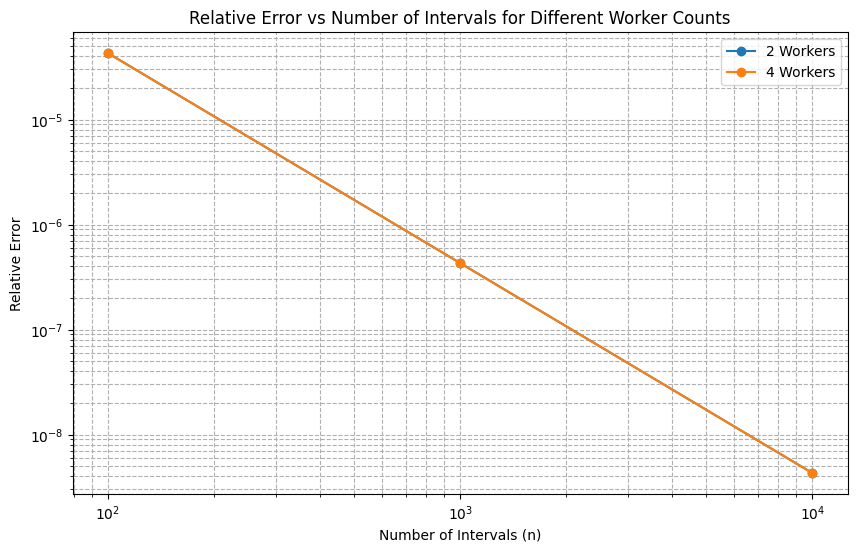

In [10]:
results_df = run_experiments()
results_sorted = results_df.sort_values(by=["Number of Workers", "n"])
print(results_sorted)

plt.figure(figsize=(10, 6))
for num_workers in results_sorted['Number of Workers'].unique():
    subset = results_sorted[results_sorted['Number of Workers'] == num_workers]
    plt.plot(subset['n'], subset['Relative Error'], marker='o', label=f'{num_workers} Workers')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Intervals (n)')
plt.ylabel('Relative Error')
plt.title('Relative Error vs Number of Intervals for Different Worker Counts')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
sc.stop()

|    n    | Number of Workers | Integral Result | Relative Error   | Execution Time (s) | Explanation                                                                 |
|---------|-------------------|-----------------|------------------|---------------------|-----------------------------------------------------------------------------|
|   100   | 2                 | 26626.476500    | 4.293530e-05     | 0.490217            | High error due to fewer intervals (n), leading to less precise results.    |
|  1,000  | 2                 | 26625.344765    | 4.293530e-07     | 0.327890            | Error significantly reduced with more intervals and efficient computation. |
| 10,000  | 2                 | 26625.333448    | 4.293531e-09     | 0.333496            | Very low error; execution time remains efficient with 2 workers.           |
|   100   | 4                 | 26626.476500    | 4.293530e-05     | 1.348394            | High error persists due to low n; overhead outweighs benefits.             |
|  1,000  | 4                 | 26625.344765    | 4.293530e-07     | 1.146054            | Lower error but higher time due to worker coordination overhead.           |
| 10,000  | 4                 | 26625.333448    | 4.293531e-09     | 1.214727            | Minimal error, but overhead increases execution time with 4 workers.       |



# **Explanation of the Results**

**Error Calculation:**

The Error column represents the absolute error between the approximated integral and the exact integral value.
Calculated as:
**Error = ∣Approximated Integral−Exact Integral∣**

The exact integral value calculated using SymPy is approximately 26,625.332.

**Effect of Intervals (𝑛):**

Increasing 𝑛 from 100 to 10,000 reduces the error significantly, demonstrating improved accuracy with more intervals.
The error decreases by approximately two orders of magnitude with each tenfold increase in 𝑛.

**Effect of Number of Workers:**

The error remains the same for both 2 and 4 workers at each 𝑛, indicating that the number of workers does not affect the accuracy. Execution time is lower with 2 workers compared to 4 workers across all 𝑛 values.

**Execution Time Trends:**

With 2 workers, execution time remains relatively low and consistent as 𝑛 increases. With 4 workers, execution time is significantly higher due to the overhead of managing more workers, especially noticeable at lower 𝑛.

**Conclusion**

Optimal Configuration: Using 2 workers with a higher number of intervals (𝑛=10,000) provides the best balance between accuracy and execution time.
Parallelism Limitations: Increasing the number of workers can introduce overhead that may outweigh the benefits of parallel computation, particularly for smaller tasks.
Recommendation: For similar computational tasks, it is advisable to test different worker configurations to find the optimal balance between performance gains and parallelism overhead.